In [1]:
import dashboardFunctions as dashFunc
from datetime import datetime
import pandas as pd
from loguru import logger


/Users/rsn/miniconda2/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [2]:
### setup logging file
logger.add("logfile_create_dashboard_{time}.log")

1

In [3]:
### create dictionary of sites key for filePrefix, nearestNeighbors
sites_dict = pd.read_csv('params/sitesDictionaryPanel.csv').set_index('refDes').T.to_dict('series')

### create dictionary of parameter vs variable Name
variable_dict = pd.read_csv('params/variableMap.csv', index_col=0, squeeze=True).to_dict()

### create dictionary of instrumet key for plot parameters
instrument_dict = pd.read_csv('params/plotParameters.csv').set_index('instrument').T.to_dict('series')

### create dictionary of variable parameters for plotting
variable_paramDict = pd.read_csv('params/variableParameters.csv').set_index('variable').T.to_dict('series')

#plotDir = '/Users/rsn/Desktop/FileCabinet/RCA_tools/QAQC_dashboard/QAQCplots/'
plotDir = 'QAQCplotsTEST/'

In [4]:
timeString = '2020-06-30'
timeRef = datetime.strptime(timeString, '%Y-%m-%d')
plotInstrument = 'CTD-PROFILER'
#plotInstrument = 'CTD-FIXED'
#timeRef = date.today()

### options...instrument, timeReference, range

In [5]:
### For each param in instrument, append to list of params in checkbox
paramList=[]
for param in instrument_dict[plotInstrument]['plotParameters'].replace('"','').split(','):
    paramList.append(param)


In [6]:
dataList = []
for key,values in sites_dict.items():
    if plotInstrument in sites_dict[key]['instrument']:
        dataList.append(key)
    
print(dataList)

['RS01SBPS-SF01A-2A-CTDPFA102', 'CE04OSPS-SF01B-2A-CTDPFA107', 'RS03AXPS-SF03A-2A-CTDPFA302']


2021-10-21 14:34:16.945 | INFO     | __main__:<module>:6 - site: CE04OSPS-SF01B-2A-CTDPFA107
/Users/rsn/miniconda2/lib/python3.7/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
2021-10-21 14:34:49.776 | INFO     | __main__:<module>:11 - paramter: temperature


plotting timeSpan:  1
slice is empty!
plotting timeSpan:  7
slice is empty!
plotting timeSpan:  30
slice is empty!
plotting timeSpan:  365


KeyboardInterrupt: 

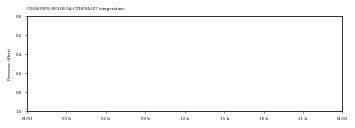

In [7]:
dataListTest = dataList[1:2]
paramListTest = paramList[0:1]

for site in dataListTest:
    plotList = []
    logger.info("site: {}", site)
    # load data for site
    siteData = dashFunc.loadData(site,sites_dict)
    fileParams = sites_dict[site]['dataParameters'].strip('"').split(',')
    for param in paramList:
        logger.info("paramter: {}", param)
        variableParams = variable_dict[param].strip('"').split(',')
        parameterList = [value for value in variableParams if value in fileParams] 
        if len(parameterList) != 1:
            logger.info("Error retriving parameter name...")
        else:
            Yparam = parameterList[0]
            # set up plotting parameters
            imageName_base = plotDir + site + '_' + param  
            plotTitle = site + ' ' + param
            paramMin = variable_paramDict[param]['min']
            paramMax = variable_paramDict[param]['max']
            profile_paramMin = variable_paramDict[param]['profileMin']
            profile_paramMax = variable_paramDict[param]['profileMax']
            yLabel = variable_paramDict[param]['label']
        
            # Load overlayData
            overlayData_clim = {}
            overlayData_grossRange = {}
            sensorType = site.split('-')[3][0:5].lower()
            (overlayData_grossRange, overlayData_clim) = dashFunc.loadQARTOD(site,Yparam,sensorType)
            overlayData_near = {}
            #overlayData_near = loadNear(site)
        
            if 'PROFILER' in plotInstrument:
                #TODO extract profiles???
                profile_paramMin = variable_paramDict[param]['profileMin']
                profile_paramMax = variable_paramDict[param]['profileMax']
                pressureParams = variable_dict['pressure'].strip('"').split(',')
                pressureParamList = [value for value in pressureParams if value in fileParams]
                if len(pressureParamList) != 1:
                    logger.info("Error retriving pressure parameter!")
                else:
                    pressParam = pressureParamList[0]
                    paramData = siteData[[Yparam,pressParam]]
                    colorMap = 'cmo.' + variable_paramDict[param]['colorMap']
                    depthMinMax = sites_dict[site]['depthMinMax'].strip('"').split(',')
                    if 'None' not in depthMinMax:
                        yMin = int(depthMinMax[0])
                        yMax = int(depthMinMax[1])
                    plots = dashFunc.plotProfilesGrid(Yparam,paramData,plotTitle,yLabel,timeRef,yMin,yMax,profile_paramMin,profile_paramMax,colorMap,imageName_base,overlayData_clim,overlayData_near)
                    plotList.append(plots)
                    depths = sites_dict[site]['depths'].strip('"').split(',')
                    if 'Single' not in depths:
                        for profileDepth in depths:
                            paramData_depth = paramData[Yparam].where((int(profileDepth) < paramData[pressParam]) & (paramData[pressParam] < (int(profileDepth)+0.5)))
                            plotTitle_depth = plotTitle + ': ' + profileDepth + ' meters'
                            imageName_base_depth = imageName_base + '_' + profileDepth + 'meters'
                            if overlayData_clim:
                                overlayData_clim_extract = dashFunc.extractClim(timeRef,profileDepth,overlayData_clim)
                            else:
                                overlayData_clim_extract = pd.DataFrame()
                            plots = dashFunc.plotScatter(Yparam,paramData_depth,plotTitle_depth,yLabel,timeRef,profile_paramMin,profile_paramMax,imageName_base_depth,overlayData_clim_extract,overlayData_near,'medium')
                            plotList.append(plots)
            else:
                paramData = siteData[Yparam]
                if overlayData_clim:
                    overlayData_clim_extract = dashFunc.extractClim(timeRef,'0',overlayData_clim)
                else:
                    overlayData_clim_extract = pd.DataFrame()
                # PLOT
                plots = dashFunc.plotScatter(Yparam,paramData,plotTitle,yLabel,timeRef,paramMin,paramMax,imageName_base,overlayData_clim_extract,overlayData_near,'small')
                plotList.append(plots)

            del paramData
            gc.collect()
    del siteData
    gc.collect()
                 